In [235]:
import os
import pandas as pd
import glob
import re
import nltk
import numpy as np

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

import gensim
from gensim import corpora
from gensim.models import LsiModel

from gensim.models.coherencemodel import CoherenceModel

import matplotlib.pyplot as plt

import seaborn as sb
import numpy as np
from textblob import TextBlob

##### Get the Scripts directory

In [70]:
scripts_dir = os.path.join(os.getcwd(),'scripts')

##### Create the structured dataframe for the unstructured texts

In [71]:
column_names = ['Original File','Season','Episode', 'Episode Name','Script']
script_df = pd.DataFrame(columns=column_names)

In [72]:
print("The dataset consists of {} episodes.".format(len(os.listdir(scripts_dir))))

The dataset consists of 228 episodes.


In [73]:
script_df['Original File'] = os.listdir(scripts_dir)

In [74]:
script_df

,Original File,Season,Episode,Episode Name,Script
0,S01E01 Monica Gets A Roommate.txt,NaN,NaN,NaN,NaN
1,S01E02 The Sonogram At The End.txt,NaN,NaN,NaN,NaN
2,S01E03 The Thumb.txt,NaN,NaN,NaN,NaN
3,S01E04 George Stephanopoulos.txt,NaN,NaN,NaN,NaN
4,S01E05 The East German Laundry Detergent.txt,NaN,NaN,NaN,NaN
...,...,...,...,...,...
223,S10E13 Joey Speaks French.txt,NaN,NaN,NaN,NaN
224,S10E14 Princess Consuela.txt,NaN,NaN,NaN,NaN
225,S10E15 Estelle Dies.txt,NaN,NaN,NaN,NaN
226,S10E16 Rachels Going Away Party.txt,NaN,NaN,NaN,NaN


In [10]:
# season_list = []
# episode_list = []
# for index, row in script_df.iterrows():
#     #print(row['Original File'])
#     x = re.search("S[0-9]{2}",row['Original File'])
#     y = re.search("E[0-9]{2}",row['Original File'])
#     y.group
#     try:
#         season_list.append(x.group(0)[1:])
#     except(AttributeError) as e:
#         season_list.append(row['Original File'])  #'s03E25 At The Beach.txt'

##### Get Season Num, Episode Num & Episode Name from filename

In [75]:
season_list = []
episode_list = []
episode_name_list = []
for index, row in script_df.iterrows():
    #print(row['Original File'])
    x = re.findall("S[0-9]{2}",row['Original File'])
    season_list.append(x[0][1:])
    y = re.findall("E[0-9]{2}",row['Original File'])
    episode_list.append(''.join(y))
    z = re.findall("[a-zA-Z\-\.\s]*.txt",row['Original File']) #'s03E25 At The Beach.txt'
    episode_name_list.append(z[0][1:-4])

In [76]:
script_df['Season'] = season_list
script_df['Episode'] = episode_list
script_df['Episode Name'] = episode_name_list

In [77]:
script_df

,Original File,Season,Episode,Episode Name,Script
0,S01E01 Monica Gets A Roommate.txt,01,E01,Monica Gets A Roommate,NaN
1,S01E02 The Sonogram At The End.txt,01,E02,The Sonogram At The End,NaN
2,S01E03 The Thumb.txt,01,E03,The Thumb,NaN
3,S01E04 George Stephanopoulos.txt,01,E04,George Stephanopoulos,NaN
4,S01E05 The East German Laundry Detergent.txt,01,E05,The East German Laundry Detergent,NaN
...,...,...,...,...,...
223,S10E13 Joey Speaks French.txt,10,E13,Joey Speaks French,NaN
224,S10E14 Princess Consuela.txt,10,E14,Princess Consuela,NaN
225,S10E15 Estelle Dies.txt,10,E15,Estelle Dies,NaN
226,S10E16 Rachels Going Away Party.txt,10,E16,Rachels Going Away Party,NaN


##### Create the Scripts Column that stores the screenplay text for each episode

In [78]:
text = ""
script_list = []
for file in glob.glob(scripts_dir+"\\*.txt"):
    f = open(file, 'r',encoding='utf8')
    text = f.read()
    script_list.append(text)
    f.close()

In [79]:
script_df['Script'] = script_list

In [80]:
script_df

,Original File,Season,Episode,Episode Name,Script
0,S01E01 Monica Gets A Roommate.txt,01,E01,Monica Gets A Roommate,The One Where Monica Gets a New Roommate (The ...
1,S01E02 The Sonogram At The End.txt,01,E02,The Sonogram At The End,The One With the Sonogram at the End\nWritten ...
2,S01E03 The Thumb.txt,01,E03,The Thumb,The One With the Thumb\nWritten by: Jeffrey As...
3,S01E04 George Stephanopoulos.txt,01,E04,George Stephanopoulos,The One With George Stephanopoulos\nWritten by...
4,S01E05 The East German Laundry Detergent.txt,01,E05,The East German Laundry Detergent,The One With the East German Laundry Detergent...
...,...,...,...,...,...
223,S10E13 Joey Speaks French.txt,10,E13,Joey Speaks French,Friends\n1013 - The One Where Joey Speaks Fren...
224,S10E14 Princess Consuela.txt,10,E14,Princess Consuela,Friends\n1014 - The One With Princess Consuela...
225,S10E15 Estelle Dies.txt,10,E15,Estelle Dies,\n1015 - The One Where Estelle Dies\nTeleplay ...
226,S10E16 Rachels Going Away Party.txt,10,E16,Rachels Going Away Party,Friends\n1016 - The One With Rachel's Going Aw...


##### Dataframe is ready

In [17]:
# Document similarity
# Perform stop word removal
# Stemming

#### It is important to clean the screenplay text for each episode

In [81]:
### Let's look at an example of how a computer sees the text

script_df['Script'][0]

'The One Where Monica Gets a New Roommate (The Pilot-The Uncut Version)\nWritten by: Marta Kauffman & David Crane\n\n\n[Scene: Central Perk, Chandler, Joey, Phoebe, and Monica are there.]\n\nMonica: There\'s nothing to tell! He\'s just some guy I work with!\n\nJoey: C\'mon, you\'re going out with the guy! There\'s gotta be something wrong with him!\n\nChandler: All right Joey, be nice.  So does he have a hump? A hump and a hairpiece?\n\nPhoebe: Wait, does he eat chalk?\n\n(They all stare, bemused.)\n\nPhoebe: Just, \'cause, I don\'t want her to go through what I went through with Carl- oh!\n\nMonica: Okay, everybody relax. This is not even a date. It\'s just two people going out to dinner and- not having sex.\n\nChandler: Sounds like a date to me.\n\n[Time Lapse]\n\nChandler: Alright, so I\'m back in high school, I\'m standing in the middle of the cafeteria, and I realize I am totally naked.\n\nAll: Oh, yeah. Had that dream.\n\nChandler: Then I look down, and I realize there\'s a phone

In [108]:
#characters of interest, ignore dialogues from other characters
names = ['Phoebe', 'Monica', 'Rachel', 'Chandler', 'Joey', 'Ross']
names = [x.upper() for x in names]
names

['PHOEBE', 'MONICA', 'RACHEL', 'CHANDLER', 'JOEY', 'ROSS']

In [83]:
season02_df = script_df[script_df['Season'] == '02']
season02_df

,Original File,Season,Episode,Episode Name,Script
24,S02E01 Rosss New Girlfriend.txt,02,E01,Rosss New Girlfriend,The One With Ross' New Girlfriend\nWritten by:...
25,S02E02 The Breast Milk.txt,02,E02,The Breast Milk,The One With the Breast Milk\nWritten by: Adam...
26,S02E03 Heckles Dies.txt,02,E03,Heckles Dies,The One Where Mr. Heckles Dies\nOriginally wri...
27,S02E04 Phoebes Husband.txt,02,E04,Phoebes Husband,The One With Phoebe's Husband\nOriginally writ...
28,S02E05 Five Steaks And An Eggplant.txt,02,E05,Five Steaks And An Eggplant,The One With Five Steaks and an Eggplant\nOrig...
29,S02E06 The Baby On The Bus.txt,02,E06,The Baby On The Bus,The One With the Baby on the Bus\nOriginally w...
30,S02E07 Ross Finds Out.txt,02,E07,Ross Finds Out,The One Where Ross Finds Out\nOriginally writt...
31,S02E08 The List.txt,02,E08,The List,The One With the List\nOriginally written by M...
32,S02E09 Phoebes Dad.txt,02,E09,Phoebes Dad,The One With Phoebe's Dad\nOriginally written ...
33,S02E10 Russ.txt,02,E10,Russ,The One With Russ\nWritten by Ira Ungerlieder....


##### Create a DF to store episode name, characters, and their cleaned lines

In [109]:
season_dialogues = pd.DataFrame(columns=["Season","Episode Name","Character", "Line"])

##### Functions to clean text

In [110]:
def remove_scene_details(line):
    clean_line = re.sub("[\(\[].*?[\)\]]", "", line) #regex to remove anything appearing between () and []
    return clean_line

In [111]:
def preprocess_text(data):
    for value in data:
        line = value[1]
        bracket_count = line.count("(")
        #print(bracket_count)
        if bracket_count == 0:
            continue
        else:
            #print(line)
            clean_line = remove_scene_details(line)
            #print(clean_line)
        
        value[1] = clean_line

    return data

In [112]:
def create_episode_dataframe(season_val, ep_name, data):
    temp_df = pd.DataFrame(data, columns = ["Character", "Line"])
    temp_df.insert(0, 'Episode Name', ep_name)
    temp_df.insert(0, 'Season', season_val)

    return temp_df

### Loop for first season

In [105]:
for index, value in season02_df.iterrows():
    ep_name = value['Episode Name']
    season_val = value['Season']
    #print(ep_name)
    print("Analyzing.....{} {}".format(season_val,ep_name))
    lines = value['Script']
    lines_list = lines.splitlines() #Create a list by splitting on '\n'

    lines_list = [x for x in lines_list if x] #removes any '' NULL dialogues

    data = []
    for line in lines_list:
        # print(line)
        if ":" in line:
            splitline = line.split(': ',maxsplit=1) #Take only the first occurence of ':'
            #print(splitline[0])
            splitline[0] = splitline[0].upper()
            if splitline[0] in names:   #if the dialogue is by a character of interest, ignore everything else
                data.append(splitline)   

    #data list is created with 2 values [Character Name, Dialogue]

    #Loop to check if the split on ':' worked or not, ideally nothing should be printed.
    for temp_val in range(len(data)):
        if len(data[temp_val]) > 2:
            print(temp_val)
            print(data[temp_val], '\n')

    data = preprocess_text(data)

    temp_df = create_episode_dataframe(season_val,ep_name,data) #this temp_df is created for every episode

    season_dialogues = pd.concat([season_dialogues,temp_df],axis=0) #This is a growing dataframe, new episodes are appended

Analyzing.....02 Rosss New Girlfriend
Analyzing.....02 The Breast Milk
Analyzing.....02 Heckles Dies
Analyzing.....02 Phoebes Husband
Analyzing.....02 Five Steaks And An Eggplant
Analyzing.....02 The Baby On The Bus
Analyzing.....02 Ross Finds Out
Analyzing.....02 The List
Analyzing.....02 Phoebes Dad
Analyzing.....02 Russ
Analyzing.....02 The Lesbian Wedding
Analyzing.....02 The Superbowl
Analyzing.....02 The Prom Video
Analyzing.....02 Ross And Rachel... You Know
Analyzing.....02 Joey Moves Out
Analyzing.....02 Eddie Moves In
Analyzing.....02 Dr. Ramoray Dies
Analyzing.....02 Eddie Wont Go
Analyzing.....02 Old Yeller Dies
Analyzing.....02 The Bullies
Analyzing.....02 The Two Parties
Analyzing.....02 The Chicken Pox
Analyzing.....02 Barry And Mindys Wedding


In [114]:
season_dialogues.reset_index(drop=True,inplace=True)

In [115]:
season_dialogues

,Season,Episode Name,Character,Line
0,01,Monica Gets A Roommate,MONICA,There's nothing to tell! He's just some guy I ...
1,01,Monica Gets A Roommate,JOEY,"C'mon, you're going out with the guy! There's ..."
2,01,Monica Gets A Roommate,CHANDLER,"All right Joey, be nice. So does he have a hu..."
3,01,Monica Gets A Roommate,PHOEBE,"Wait, does he eat chalk?"
4,01,Monica Gets A Roommate,PHOEBE,"Just, 'cause, I don't want her to go through w..."
...,...,...,...,...
50504,10,The Last One Part I II,CHANDLER,"Oh, it's gonna be okay."
50505,10,The Last One Part I II,RACHEL,Do you guys have to go to the new house right...
50506,10,The Last One Part I II,MONICA,We got some time.
50507,10,The Last One Part I II,RACHEL,"Okay, should we get some coffee?"


In [ ]:
season_dialogues

### All seasons

In [113]:
for index, value in script_df.iterrows():
    ep_name = value['Episode Name']
    season_val = value['Season']
    #print(ep_name)
    print("Analyzing.....{} {}".format(season_val,ep_name))
    lines = value['Script']
    lines_list = lines.splitlines() #Create a list by splitting on '\n'

    lines_list = [x for x in lines_list if x] #removes any '' NULL dialogues

    data = []
    for line in lines_list:
        # print(line)
        if ":" in line:
            splitline = line.split(': ',maxsplit=1) #Take only the first occurence of ':'
            #print(splitline[0])
            splitline[0] = splitline[0].upper()
            if splitline[0] in names:   #if the dialogue is by a character of interest, ignore everything else
                data.append(splitline)   

    #data list is created with 2 values [Character Name, Dialogue]

    #Loop to check if the split on ':' worked or not, ideally nothing should be printed.
    for temp_val in range(len(data)):
        if len(data[temp_val]) > 2:
            print(temp_val)
            print(data[temp_val], '\n')

    data = preprocess_text(data)

    temp_df = create_episode_dataframe(season_val,ep_name,data) #this temp_df is created for every episode

    season_dialogues = pd.concat([season_dialogues,temp_df],axis=0) #This is a growing dataframe, new episodes are appended

Analyzing.....01 Monica Gets A Roommate
Analyzing.....01 The Sonogram At The End
Analyzing.....01 The Thumb
Analyzing.....01 George Stephanopoulos
Analyzing.....01 The East German Laundry Detergent
Analyzing.....01 The Butt
Analyzing.....01 The Blackout
Analyzing.....01 Nana Dies Twice
Analyzing.....01 Underdog Gets Away
Analyzing.....01 The Monkey
Analyzing.....01 Mrs. Bing
Analyzing.....01 The Dozen Lasagnas
Analyzing.....01 The Boobies
Analyzing.....01 The Candy Hearts
Analyzing.....01 The Stoned Guy
Analyzing.....01 The Two Parts Part I
Analyzing.....01 The Two Parts Part II
Analyzing.....01 All The Poker
Analyzing.....01 The Monkey Gets Away
Analyzing.....01 The Evil Orthodontist
Analyzing.....01 The Fake Monica
Analyzing.....01 The Ick Factor
Analyzing.....01 The Birth
Analyzing.....01 Rachel Finds Out
Analyzing.....02 Rosss New Girlfriend
Analyzing.....02 The Breast Milk
Analyzing.....02 Heckles Dies
Analyzing.....02 Phoebes Husband
Analyzing.....02 Five Steaks And An Eggplant
A

##### Sentiment Analysis

In [116]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

In [117]:
sia = SentimentIntensityAnalyzer()

In [118]:
def calculate_sentiment(dialogue):
    f = sia.polarity_scores(dialogue.strip())
    scores = f['pos'], f['neg'], f['neu']
    return scores

In [119]:
scores_list = []
for index, value in season_dialogues.iterrows():
    #print(value["Line"])
    dialogue = value["Line"]
    scores = calculate_sentiment(dialogue)
    scores_list.append(scores)

In [120]:
scores_df = pd.DataFrame(scores_list, columns=['Positive','Negative','Neutral'])

In [121]:
scores_df

,Positive,Negative,Neutral
0,0.000,0.000,1.000
1,0.000,0.221,0.779
2,0.208,0.000,0.792
3,0.000,0.000,1.000
4,0.000,0.104,0.896
...,...,...,...
50504,0.322,0.000,0.678
50505,0.000,0.000,1.000
50506,0.000,0.000,1.000
50507,0.275,0.000,0.725


##### Merge sentiment scores with the episodes and lines

In [122]:
final_all_seasondf = pd.concat([season_dialogues, scores_df],axis=1) #axis = 1 for column stacking vertically

In [123]:
final_all_seasondf

,Season,Episode Name,Character,Line,Positive,Negative,Neutral
0,01,Monica Gets A Roommate,MONICA,There's nothing to tell! He's just some guy I ...,0.000,0.000,1.000
1,01,Monica Gets A Roommate,JOEY,"C'mon, you're going out with the guy! There's ...",0.000,0.221,0.779
2,01,Monica Gets A Roommate,CHANDLER,"All right Joey, be nice. So does he have a hu...",0.208,0.000,0.792
3,01,Monica Gets A Roommate,PHOEBE,"Wait, does he eat chalk?",0.000,0.000,1.000
4,01,Monica Gets A Roommate,PHOEBE,"Just, 'cause, I don't want her to go through w...",0.000,0.104,0.896
...,...,...,...,...,...,...,...
50504,10,The Last One Part I II,CHANDLER,"Oh, it's gonna be okay.",0.322,0.000,0.678
50505,10,The Last One Part I II,RACHEL,Do you guys have to go to the new house right...,0.000,0.000,1.000
50506,10,The Last One Part I II,MONICA,We got some time.,0.000,0.000,1.000
50507,10,The Last One Part I II,RACHEL,"Okay, should we get some coffee?",0.275,0.000,0.725


In [124]:
final_all_seasondf.to_csv('sentiment_seasons.csv',index=False)

In [136]:
final_all_seasondf[final_all_seasondf['Neutral'] >= 0.5]

,Season,Episode Name,Character,Line,Positive,Negative,Neutral
0,01,Monica Gets A Roommate,MONICA,There's nothing to tell! He's just some guy I ...,0.000,0.000,1.000
1,01,Monica Gets A Roommate,JOEY,"C'mon, you're going out with the guy! There's ...",0.000,0.221,0.779
2,01,Monica Gets A Roommate,CHANDLER,"All right Joey, be nice. So does he have a hu...",0.208,0.000,0.792
3,01,Monica Gets A Roommate,PHOEBE,"Wait, does he eat chalk?",0.000,0.000,1.000
4,01,Monica Gets A Roommate,PHOEBE,"Just, 'cause, I don't want her to go through w...",0.000,0.104,0.896
...,...,...,...,...,...,...,...
50503,10,The Last One Part I II,MONICA,This is harder than I thought it would be.,0.000,0.000,1.000
50504,10,The Last One Part I II,CHANDLER,"Oh, it's gonna be okay.",0.322,0.000,0.678
50505,10,The Last One Part I II,RACHEL,Do you guys have to go to the new house right...,0.000,0.000,1.000
50506,10,The Last One Part I II,MONICA,We got some time.,0.000,0.000,1.000


In [320]:
final_all_seasondf['Sentiment'] = list(final_all_seasondf[['Positive','Negative','Neutral']].idxmax(axis=1))

### Sentiment per Character by Season

In [321]:
P = final_all_seasondf[['Season','Character','Sentiment']].groupby(['Season','Character','Sentiment']).size().to_frame('Count').reset_index()
P.head(50)

,Season,Character,Sentiment,Count
0,01,CHANDLER,Negative,23
1,01,CHANDLER,Neutral,726
2,01,CHANDLER,Positive,68
3,01,JOEY,Negative,18
4,01,JOEY,Neutral,569
5,01,JOEY,Positive,53
6,01,MONICA,Negative,32
7,01,MONICA,Neutral,762
8,01,MONICA,Positive,78
9,01,PHOEBE,Negative,20


In [170]:
# Remove Neutral for comparison

P_neutral = P[P.Sentiment != 'Neutral']
P_neutral

,Season,Character,Sentiment,Count
0,01,CHANDLER,Negative,23
2,01,CHANDLER,Positive,68
3,01,JOEY,Negative,18
5,01,JOEY,Positive,53
6,01,MONICA,Negative,32
...,...,...,...,...
173,10,PHOEBE,Positive,81
174,10,RACHEL,Negative,23
176,10,RACHEL,Positive,116
177,10,ROSS,Negative,44


In [184]:
P_neutral['percent'] = list(P_neutral['Count'] / P_neutral.groupby(['Season','Character'])['Count'].transform('sum'))
P_neutral.head(50)


C:\Users\nikhi\AppData\Local\Temp\ipykernel_15396\2146951259.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  P_neutral['percent'] = list(P_neutral['Count'] / P_neutral.groupby(['Season','Character'])['Count'].transform('sum'))


,Season,Character,Sentiment,Count,percent
0,01,CHANDLER,Negative,23,0.252747
2,01,CHANDLER,Positive,68,0.747253
3,01,JOEY,Negative,18,0.253521
5,01,JOEY,Positive,53,0.746479
6,01,MONICA,Negative,32,0.290909
8,01,MONICA,Positive,78,0.709091
9,01,PHOEBE,Negative,20,0.192308
11,01,PHOEBE,Positive,84,0.807692
12,01,RACHEL,Negative,26,0.209677
14,01,RACHEL,Positive,98,0.790323


In [185]:
P_neutral.to_csv('sentiment_counts.csv',index=False)

In [195]:
season_senti = final_all_seasondf[['Season','Character','Sentiment']].groupby(['Season','Sentiment']).size().to_frame('Count').reset_index()
season_senti

# Remove Neutral for comparison

season_senti = season_senti[season_senti.Sentiment != 'Neutral']
season_senti

season_senti['percent'] = list(season_senti['Count'] / season_senti.groupby(['Season'])['Count'].transform('sum'))
season_senti.head(50)

,Season,Sentiment,Count,percent
0,01,Negative,156,0.252427
2,01,Positive,462,0.747573
3,02,Negative,118,0.210714
5,02,Positive,442,0.789286
6,03,Negative,182,0.227500
8,03,Positive,618,0.772500
9,04,Negative,165,0.200730
11,04,Positive,657,0.799270
12,05,Negative,187,0.215935
14,05,Positive,679,0.784065


In [196]:
season_senti.to_csv('season_sentiments.csv',index=False)

In [322]:
senti_character = final_all_seasondf[['Character','Sentiment']].groupby(['Character','Sentiment']).size().to_frame('Count').reset_index()
senti_character.head(50)

,Character,Sentiment,Count
0,CHANDLER,Negative,272
1,CHANDLER,Neutral,7199
2,CHANDLER,Positive,908
3,JOEY,Negative,266
4,JOEY,Neutral,7082
5,JOEY,Positive,867
6,MONICA,Negative,271
7,MONICA,Neutral,7104
8,MONICA,Positive,905
9,PHOEBE,Negative,233


In [323]:
# Remove Neutral for comparison

senti_character = senti_character[senti_character.Sentiment != 'Neutral']
senti_character

senti_character['percent'] = list(senti_character['Count'] / senti_character.groupby(['Character'])['Count'].transform('sum'))
senti_character.head(50)

,Character,Sentiment,Count,percent
0,CHANDLER,Negative,272,0.230508
2,CHANDLER,Positive,908,0.769492
3,JOEY,Negative,266,0.234775
5,JOEY,Positive,867,0.765225
6,MONICA,Negative,271,0.230442
8,MONICA,Positive,905,0.769558
9,PHOEBE,Negative,233,0.200862
11,PHOEBE,Positive,927,0.799138
12,RACHEL,Negative,287,0.185881
14,RACHEL,Positive,1257,0.814119


In [324]:
senti_character.to_csv('senti_character.csv',index=False)

##### IDEAS

* TF-IDF on Characters' diaglogues for a season
* Consider all the lines by a character for the entire season as a document
* so we have 6 documents in total for 6 characters
* for each character, we get the most important words spoken by them for that season
* can LSA work better than TF-IDF?
* Terms vs concepts
* stop word removal
* TF-IDF and then SVD on it

In [197]:
# Clustering dialogues - Stop word removal, Stemming, TF-IDF, K-Means Clustering
# Refer practice problem 3
# Stanford NLP

# Explore - https://towardsdatascience.com/text-visualization-of-stand-up-comedy-with-scattertext-2ec2fa21139d

# Word2Vec on Dialogues

# https://github.com/tgll/word2vec_withfriends

# https://medium.com/swlh/text-analytics-on-friends-tv-series-10-episodes-42875804f3a6

# https://github.com/apswin/friendstvseries/blob/main/Friends%20Episodes%20-%20Script%20Analysis.ipynb

In [198]:
phoebe_text = list(final_all_seasondf[final_all_seasondf.Character == 'PHOEBE'].Line)
ross_text = list(final_all_seasondf[final_all_seasondf.Character == 'ROSS'].Line)
chandler_text = list(final_all_seasondf[final_all_seasondf.Character == 'CHANDLER'].Line)
joey_text = list(final_all_seasondf[final_all_seasondf.Character == 'JOEY'].Line)
monica_text = list(final_all_seasondf[final_all_seasondf.Character == 'MONICA'].Line)
rachel_text = list(final_all_seasondf[final_all_seasondf.Character == 'RACHEL'].Line)

In [199]:
phoebe_text

['Wait, does he eat chalk?',
 "Just, 'cause, I don't want her to go through what I went through with Carl- oh!",
 'No.',
 'Ooh! Oh! ',
 'Fine!  Be murky!',
 ' If I let go of my hair, my head will fall off.',
 ' Raindrops on roses and rabbits and kittens,  bluebells and sleighbells and- something with mittens... La la la la...something and noodles with string.  These are a few...',
 ' I helped!',
 'What does that mean?   Does he sell it, drink it, or just complain a lot? ',
 "Ooh, I just pulled out four eyelashes. That can't be good.",
 "Oh, I wish I could, but I don't want to.",
 ' Love is sweet as summer showers, love is a wondrous work of art, but your love oh your love, your love...is like a giant pigeon...crapping on my heart.  La-la-la-la-la-  Thank you.  La-la-la-la...ohhh!',
 "Oh no, don't hate, you don't want to put that out into the universe.",
 "All right, c'mere, gimme your feet. ",
 "Give her a break, it's hard being on your own for the first time.",
 "You're welcome. I rem

In [201]:
def preprocess_data(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts

In [202]:
clean_documents_list=preprocess_data(phoebe_text)

In [318]:
en_stop = set(stopwords.words('english'))
en_stop

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [205]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

In [206]:
term_dictionary, doc_term_matrix = prepare_corpus(clean_documents_list)

In [208]:
start,stop,step=2,12,1

In [211]:
def plot_graph(coherence_values,start, stop, step):
    '''
    Input: Coherence Values, Start, Stop, Step
    Output: N/A(Should not return anything, but should plot the graph between the number of topics and coherence values.)
    '''
    # YOUR CODE HERE
    plt.plot(range(start, stop, step), coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.show()
    return

In [214]:
def compute_coherence_values(term_dictionary, doc_term_matrix, cleaned_documents_list, start, stop, step):
    """
    Input: term_dictionary, doc_term_matrix, cleaned_documents_list, 
           start(Min. number of topics),
           stop(Max. num of topics)
           step(Step size when increasing the number of topics) 
    Output  : coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    # YOUR CODE HERE
    
    mlist = []
    cval = []
    for n in range(start, stop, step):
        m = LsiModel(doc_term_matrix, num_topics=n, id2word = term_dictionary)  
        mlist.append(m)
        cval.append(CoherenceModel(model=m, texts=cleaned_documents_list, dictionary=term_dictionary, coherence='c_v').get_coherence())
    return cval

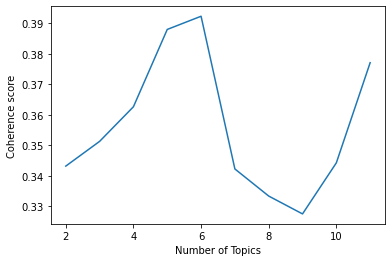

In [215]:
coherence_values = compute_coherence_values(term_dictionary, doc_term_matrix,clean_documents_list, start, stop, step)
plot_graph(coherence_values,start,stop,step)

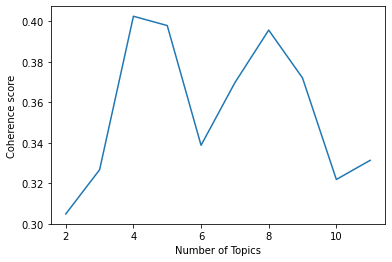

In [216]:
start,stop,step=2,12,1
clean_documents_list=preprocess_data(monica_text)
term_dictionary, doc_term_matrix = prepare_corpus(clean_documents_list)
coherence_values = compute_coherence_values(term_dictionary, doc_term_matrix,clean_documents_list, start, stop, step)
plot_graph(coherence_values,start,stop,step)

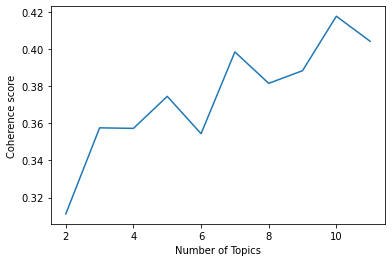

In [217]:
start,stop,step=2,12,1
clean_documents_list=preprocess_data(ross_text)
term_dictionary, doc_term_matrix = prepare_corpus(clean_documents_list)
coherence_values = compute_coherence_values(term_dictionary, doc_term_matrix,clean_documents_list, start, stop, step)
plot_graph(coherence_values,start,stop,step)

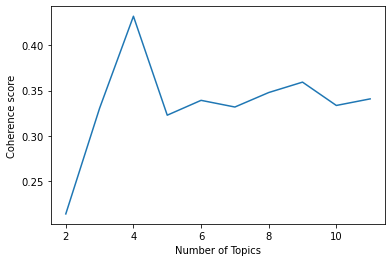

In [218]:
start,stop,step=2,12,1
clean_documents_list=preprocess_data(chandler_text)
term_dictionary, doc_term_matrix = prepare_corpus(clean_documents_list)
coherence_values = compute_coherence_values(term_dictionary, doc_term_matrix,clean_documents_list, start, stop, step)
plot_graph(coherence_values,start,stop,step)

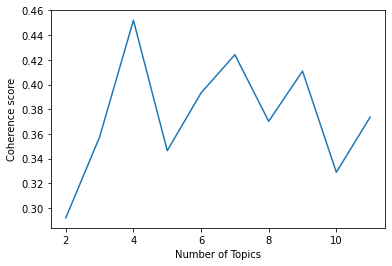

In [219]:
start,stop,step=2,12,1
clean_documents_list=preprocess_data(joey_text)
term_dictionary, doc_term_matrix = prepare_corpus(clean_documents_list)
coherence_values = compute_coherence_values(term_dictionary, doc_term_matrix,clean_documents_list, start, stop, step)
plot_graph(coherence_values,start,stop,step)

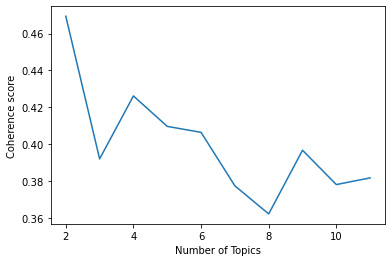

In [220]:
start,stop,step=2,12,1
clean_documents_list=preprocess_data(rachel_text)
term_dictionary, doc_term_matrix = prepare_corpus(clean_documents_list)
coherence_values = compute_coherence_values(term_dictionary, doc_term_matrix,clean_documents_list, start, stop, step)
plot_graph(coherence_values,start,stop,step)

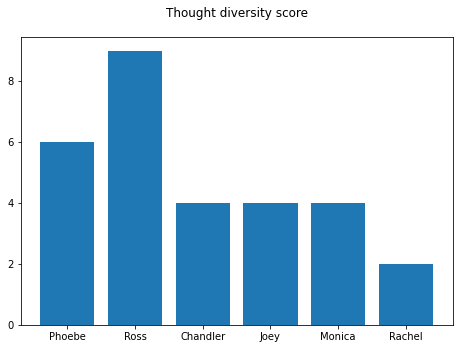

In [311]:
lchar = ['Phoebe','Ross','Chandler','Joey','Monica','Rachel']
ltopics =[6,9,4,4,4,2]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title('Thought diversity score', pad=20)
ax.bar(lchar,ltopics)
plt.show()

In [315]:
vis = gensimvis.prepare(model, doc_term_matrix, dictionary=model.id2word)
vis

c:\Users\nikhi\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.311388  0.111862       1        1  27.814714
1      0.041994 -0.279430       2        1  25.459936
3      0.217620  0.228473       3        1  25.195447
2      0.051774 -0.060905       4        1  21.529904, topic_info=        Term         Freq        Total Category  logprob  loglift
144       oh  1185.000000  1185.000000  Default  30.0000  30.0000
31      know   909.000000   909.000000  Default  29.0000  29.0000
242      hey   867.000000   867.000000  Default  28.0000  28.0000
142     yeah   852.000000   852.000000  Default  27.0000  27.0000
126    gonna   596.000000   596.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
2035   shoot    54.183811    55.331273   Topic4  -5.2024   1.5148
174   ticket    78.928084    89.060211   Topic4  -4.8263   1.4150
4428    pari    86.372265   103.960908   Topic4  -4.7361   1.3504
1794     uhm    92.065987   149.271914   Topic4  -4.6723   1.0525
762     morn    58.581980    63.986451   Topic4  -5.1244   1.4475

[161 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
304       3  0.994429   actual
21        1  0.015632  alright
21        4  0.984796  alright
117       1  0.992362    anyth
53        2  0.990395      ask
...     ...       ...      ...
169       3  0.995829    would
711       4  0.996393      wow
188       4  0.993267       ye
142       2  0.999385     yeah
81        4  0.994645     year

[157 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 3])

In [223]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """

    d,dtm=prepare_corpus(doc_clean)
    lsa = LsiModel(dtm, num_topics=number_of_topics, id2word = d)
    return lsa 

In [224]:
number_of_topics=7
words=10
model=create_gensim_lsa_model(preprocess_data(rachel_text),number_of_topics,words)
rachel_topics = model.print_topics(num_topics=number_of_topics, num_words=words)
rachel_topics

[(0,
  '0.718*"oh" + 0.402*"know" + 0.203*"god" + 0.168*"okay" + 0.129*"gonna" + 0.122*"mean" + 0.121*"well" + 0.120*"go" + 0.114*"yeah" + 0.114*"like"'),
 (1,
  '-0.624*"know" + 0.605*"oh" + 0.198*"god" + -0.187*"okay" + -0.153*"mean" + -0.133*"well" + -0.115*"gonna" + -0.110*"right" + -0.094*"like" + -0.090*"get"'),
 (2,
  '0.821*"okay" + -0.456*"know" + 0.143*"right" + 0.140*"gonna" + 0.121*"go" + 0.104*"get" + -0.079*"oh" + 0.071*"see" + 0.069*"well" + -0.057*"mean"'),
 (3,
  '-0.532*"well" + 0.404*"okay" + -0.399*"yeah" + 0.398*"know" + -0.214*"gonna" + -0.180*"go" + -0.143*"get" + -0.123*"uh" + -0.121*"think" + 0.096*"oh"'),
 (4,
  '0.818*"yeah" + -0.256*"gonna" + -0.227*"get" + -0.222*"go" + 0.211*"okay" + -0.142*"ross" + -0.104*"god" + -0.100*"right" + -0.098*"mean" + -0.090*"guy"'),
 (5,
  '-0.765*"well" + 0.313*"yeah" + 0.258*"gonna" + 0.241*"get" + 0.212*"right" + 0.172*"mean" + -0.137*"okay" + 0.129*"ross" + -0.125*"know" + 0.121*"go"'),
 (6,
  '-0.610*"gonna" + 0.581*"get"

In [225]:
number_of_topics=7
words=10
model=create_gensim_lsa_model(preprocess_data(monica_text),number_of_topics,words)
monica_topics = model.print_topics(num_topics=number_of_topics, num_words=words)
monica_topics

[(0,
  '0.447*"oh" + 0.416*"know" + 0.274*"okay" + 0.272*"go" + 0.242*"get" + 0.185*"gonna" + 0.168*"god" + 0.163*"mean" + 0.160*"right" + 0.140*"like"'),
 (1,
  '0.795*"oh" + 0.326*"god" + -0.324*"know" + -0.184*"go" + -0.175*"okay" + -0.140*"get" + -0.095*"mean" + -0.085*"think" + -0.083*"want" + -0.064*"realli"'),
 (2,
  '-0.702*"know" + 0.418*"okay" + 0.393*"get" + 0.333*"go" + 0.115*"gonna" + -0.082*"like" + -0.077*"mean" + 0.064*"right" + 0.062*"come" + 0.059*"let"'),
 (3,
  '0.801*"okay" + -0.407*"go" + -0.390*"get" + -0.089*"gonna" + -0.055*"well" + 0.051*"know" + -0.046*"yeah" + -0.043*"hey" + -0.039*"want" + -0.038*"guy"'),
 (4,
  '-0.744*"get" + 0.612*"go" + 0.121*"right" + 0.116*"gonna" + -0.105*"know" + -0.055*"marri" + 0.049*"guy" + 0.044*"well" + -0.042*"someth" + 0.041*"let"'),
 (5,
  '-0.413*"know" + -0.381*"go" + 0.326*"yeah" + 0.298*"realli" + 0.264*"mean" + 0.258*"think" + 0.193*"well" + 0.174*"like" + -0.173*"okay" + 0.158*"gonna"'),
 (6,
  '-0.879*"gonna" + 0.258*

In [314]:
number_of_topics=7
words=10
model=create_gensim_lsa_model(preprocess_data(ross_text),number_of_topics,words)
ross_topics = model.print_topics(num_topics=number_of_topics, num_words=words)
ross_topics

[(0,
  '0.048*"go" + 0.047*"get" + 0.041*"rachel" + 0.034*"guy" + 0.033*"look" + 0.032*"god" + 0.029*"right" + 0.027*"uh" + 0.025*"come" + 0.025*"good"'),
 (1,
  '0.102*"oh" + 0.073*"yeah" + 0.038*"well" + 0.031*"want" + 0.029*"say" + 0.025*"ok" + 0.022*"love" + 0.022*"got" + 0.020*"goodby" + 0.020*"never"'),
 (2,
  '0.060*"gonna" + 0.058*"okay" + 0.032*"thing" + 0.024*"one" + 0.020*"sure" + 0.019*"ye" + 0.017*"two" + 0.017*"tell" + 0.016*"wow" + 0.015*"minut"'),
 (3,
  '0.079*"know" + 0.075*"hey" + 0.030*"think" + 0.030*"monica" + 0.029*"realli" + 0.029*"like" + 0.026*"mean" + 0.022*"let" + 0.021*"would" + 0.019*"feel"')]

In [227]:
number_of_topics=7
words=10
model=create_gensim_lsa_model(preprocess_data(phoebe_text),number_of_topics,words)
phoebe_topics = model.print_topics(num_topics=number_of_topics, num_words=words)
phoebe_topics

[(0,
  '-0.618*"know" + -0.475*"oh" + -0.255*"okay" + -0.238*"like" + -0.188*"yeah" + -0.136*"well" + -0.113*"go" + -0.113*"get" + -0.110*"realli" + -0.108*"right"'),
 (1,
  '0.799*"oh" + -0.550*"know" + 0.155*"god" + -0.115*"like" + -0.042*"mean" + -0.042*"well" + -0.042*"realli" + -0.032*"gonna" + 0.029*"look" + 0.029*"hi"'),
 (2,
  '0.840*"okay" + -0.350*"know" + -0.227*"oh" + 0.133*"right" + 0.125*"well" + 0.108*"go" + 0.102*"get" + 0.085*"gonna" + -0.085*"like" + 0.071*"umm"'),
 (3,
  '-0.922*"yeah" + 0.234*"okay" + 0.205*"know" + 0.100*"oh" + -0.090*"go" + -0.068*"realli" + -0.062*"well" + -0.044*"right" + -0.042*"ok" + 0.039*"god"'),
 (4,
  '-0.682*"like" + 0.348*"know" + 0.241*"okay" + 0.215*"yeah" + -0.213*"go" + -0.188*"guy" + -0.169*"hey" + -0.151*"realli" + -0.144*"get" + 0.135*"oh"'),
 (5,
  '-0.578*"like" + 0.519*"go" + 0.307*"gonna" + -0.246*"okay" + -0.190*"yeah" + 0.179*"well" + 0.164*"hey" + 0.155*"ok" + 0.149*"get" + 0.100*"right"'),
 (6,
  '-0.788*"well" + 0.380*"he

In [228]:
number_of_topics=7
words=10
model=create_gensim_lsa_model(preprocess_data(joey_text),number_of_topics,words)
joey_topics = model.print_topics(num_topics=number_of_topics, num_words=words)
joey_topics

[(0,
  '-0.466*"know" + -0.341*"hey" + -0.297*"yeah" + -0.271*"oh" + -0.228*"like" + -0.209*"right" + -0.199*"look" + -0.187*"uh" + -0.165*"okay" + -0.164*"get"'),
 (1,
  '-0.892*"hey" + 0.292*"yeah" + 0.291*"know" + 0.092*"like" + 0.069*"oh" + 0.046*"well" + 0.036*"realli" + -0.036*"ross" + 0.034*"think" + 0.034*"mean"'),
 (2,
  '0.649*"yeah" + -0.581*"know" + 0.448*"oh" + -0.078*"look" + 0.074*"uh" + -0.060*"like" + -0.058*"guy" + -0.048*"mean" + 0.044*"hey" + -0.041*"want"'),
 (3,
  '-0.628*"oh" + 0.620*"yeah" + 0.224*"know" + 0.211*"hey" + -0.202*"okay" + -0.157*"right" + -0.110*"uh" + -0.097*"look" + -0.059*"god" + -0.052*"ross"'),
 (4,
  '0.509*"right" + -0.506*"oh" + -0.440*"know" + 0.304*"okay" + 0.253*"look" + 0.157*"go" + 0.134*"get" + -0.131*"hey" + 0.123*"like" + 0.101*"well"'),
 (5,
  '-0.651*"right" + 0.494*"uh" + 0.373*"like" + 0.229*"look" + -0.195*"know" + -0.165*"oh" + 0.140*"okay" + -0.094*"go" + 0.053*"huh" + 0.052*"think"'),
 (6,
  '-0.737*"uh" + 0.438*"like" + 0.2

In [229]:
number_of_topics=7
words=10
model=create_gensim_lsa_model(preprocess_data(chandler_text),number_of_topics,words)
chandler_topics = model.print_topics(num_topics=number_of_topics, num_words=words)
chandler_topics

[(0,
  '-0.628*"know" + -0.226*"oh" + -0.224*"okay" + -0.219*"get" + -0.209*"go" + -0.197*"well" + -0.172*"gonna" + -0.166*"like" + -0.157*"look" + -0.148*"think"'),
 (1,
  '0.630*"know" + -0.584*"oh" + -0.365*"okay" + -0.163*"yeah" + -0.144*"go" + -0.117*"right" + -0.089*"get" + -0.079*"god" + -0.063*"uh" + -0.056*"joey"'),
 (2,
  '0.653*"oh" + -0.589*"okay" + -0.279*"go" + 0.190*"know" + 0.166*"yeah" + -0.158*"get" + -0.129*"gonna" + -0.104*"look" + -0.083*"right" + 0.082*"god"'),
 (3,
  '-0.608*"okay" + 0.523*"go" + 0.341*"well" + -0.276*"know" + -0.201*"oh" + 0.135*"hey" + 0.133*"yeah" + 0.127*"get" + 0.103*"right" + 0.088*"think"'),
 (4,
  '0.680*"go" + -0.525*"well" + 0.200*"oh" + -0.187*"get" + -0.184*"yeah" + 0.184*"know" + -0.148*"look" + 0.117*"hey" + -0.109*"like" + -0.108*"think"'),
 (5,
  '-0.778*"get" + 0.397*"well" + -0.222*"hey" + 0.202*"go" + 0.200*"yeah" + 0.194*"okay" + 0.102*"like" + -0.102*"gonna" + -0.101*"right" + -0.061*"marri"'),
 (6,
  '-0.857*"hey" + 0.266*"g

In [230]:
s= chandler_topics[0][1]
s.split('"')[1::2]

['know', 'oh', 'okay', 'get', 'go', 'well', 'gonna', 'like', 'look', 'think']

In [294]:
lchar2 = [ 'rachel', 'ross','monica','phoeb', 'joey','chandler']

In [232]:
topics_list = [rachel_topics, ross_topics, monica_topics, phoebe_topics, joey_topics, chandler_topics]
character_affinity =[]
for i in range(len(lchar2)):
    tp = topics_list[i]
    ca = [0 for i in range(6)]
    for j in range(len(lchar2)):
        for k, t in enumerate(tp):
            s = t[1].split('"')[1::2]
            if(lchar2[j] in s):
                ca[j] = ca[j]+1
    character_affinity.append(ca)

In [233]:
ca_df = pd.DataFrame(character_affinity)
ca_df.columns =lchar2
ca_df.index = lchar2
ca_df

,rachel,ross,monica,phoebe,joey,chandler
rachel,0,3,0,0,0,0
ross,0,0,0,0,0,0
monica,0,0,0,0,0,0
phoebe,0,0,0,0,0,0
joey,0,2,0,0,0,0
chandler,0,0,0,0,2,0


Text(0.5, 1.0, 'Character affinity heat map')

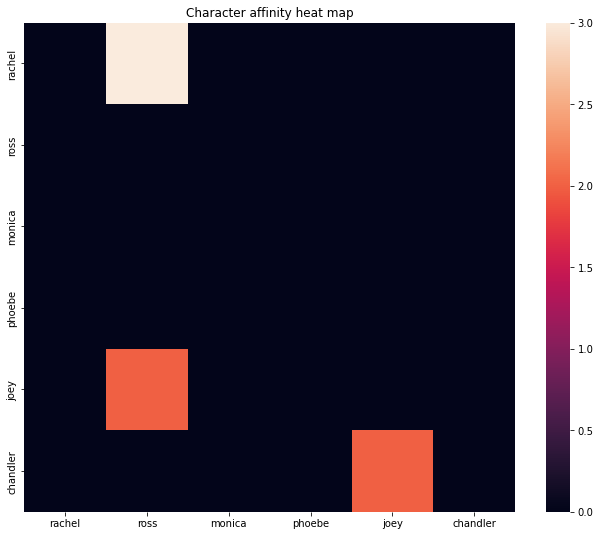

In [236]:
#plotting character affinity heatmap 
#Higher affinity towards one character means higher mentions of another character in the other character's key topics through out
fig, ax = plt.subplots(figsize=(11, 9))
sb.heatmap(ca_df)

# displaying the title 
plt.title("Character affinity heat map")

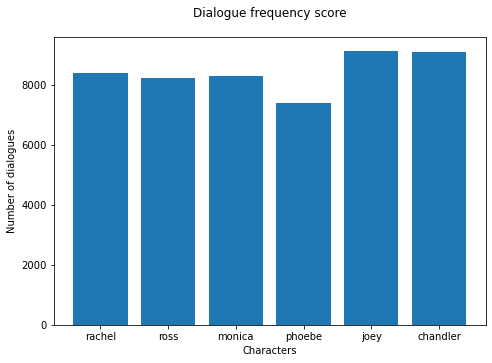

In [237]:
# Most important character by dialogues - Joey
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Dialogue frequency score", pad=20)
plt.xlabel('Characters')  
plt.ylabel('Number of dialogues') 
ax.bar(lchar2, final_all_seasondf.groupby(by=["Character"]).count()['Line'])

plt.show()

### Topic Modelling - LDA

In [277]:
def create_gensim_lda_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LDA model using gensim
    Output : return LDA model
    """

    d,dtm=prepare_corpus(doc_clean)
    #lsa = LsiModel(dtm, num_topics=number_of_topics, id2word = d)
    lda_model = gensim.models.ldamodel.LdaModel(corpus=dtm,
                                           id2word=d,
                                           num_topics=number_of_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)
    return lda_model 

In [278]:
number_of_topics=7
words=10
model=create_gensim_lda_model(preprocess_data(rachel_text),number_of_topics,words)
rachel_topics = model.print_topics(num_topics=number_of_topics, num_words=words)
rachel_topics

[(0,
  '0.110*"gonna" + 0.070*"right" + 0.061*"ok" + 0.057*"think" + 0.041*"would" + 0.039*"emma" + 0.036*"see" + 0.024*"ye" + 0.021*"even" + 0.021*"wanna"'),
 (1,
  '0.096*"want" + 0.076*"good" + 0.047*"joey" + 0.045*"said" + 0.042*"tell" + 0.029*"minut" + 0.019*"watch" + 0.019*"alreadi" + 0.019*"two" + 0.019*"aw"'),
 (2,
  '0.304*"oh" + 0.078*"yeah" + 0.068*"guy" + 0.049*"hi" + 0.046*"god" + 0.031*"one" + 0.028*"back" + 0.023*"thank" + 0.020*"job" + 0.020*"pari"'),
 (3,
  '0.098*"go" + 0.086*"ross" + 0.083*"okay" + 0.059*"love" + 0.036*"alright" + 0.035*"let" + 0.033*"thing" + 0.033*"sorri" + 0.023*"fine" + 0.023*"pleas"'),
 (4,
  '0.157*"well" + 0.043*"time" + 0.040*"wait" + 0.040*"great" + 0.037*"need" + 0.036*"call" + 0.026*"mayb" + 0.024*"everyth" + 0.023*"first" + 0.020*"ralph"'),
 (5,
  '0.073*"come" + 0.051*"believ" + 0.042*"hey" + 0.040*"phoeb" + 0.035*"gotta" + 0.031*"miss" + 0.030*"talk" + 0.029*"new" + 0.028*"monica" + 0.027*"rememb"'),
 (6,
  '0.135*"know" + 0.071*"get" +

In [279]:
number_of_topics=7
words=10
model=create_gensim_lda_model(preprocess_data(monica_text),number_of_topics,words)
monica_topics = model.print_topics(num_topics=number_of_topics, num_words=words)
monica_topics

[(0,
  '0.073*"chandler" + 0.055*"joey" + 0.049*"come" + 0.045*"phoeb" + 0.037*"much" + 0.036*"could" + 0.031*"ross" + 0.025*"uh" + 0.022*"pleas" + 0.021*"three"'),
 (1,
  '0.065*"well" + 0.043*"hous" + 0.042*"like" + 0.039*"mean" + 0.039*"make" + 0.037*"wait" + 0.034*"us" + 0.030*"care" + 0.030*"would" + 0.024*"leav"'),
 (2,
  '0.092*"hey" + 0.063*"see" + 0.061*"right" + 0.049*"one" + 0.040*"love" + 0.035*"back" + 0.023*"live" + 0.020*"pack" + 0.019*"need" + 0.016*"new"'),
 (3,
  '0.234*"oh" + 0.089*"god" + 0.051*"got" + 0.045*"realli" + 0.041*"ok" + 0.034*"sorri" + 0.034*"good" + 0.023*"honey" + 0.021*"call" + 0.014*"girl"'),
 (4,
  '0.126*"know" + 0.085*"babi" + 0.060*"think" + 0.040*"time" + 0.040*"take" + 0.029*"great" + 0.028*"said" + 0.026*"thing" + 0.025*"mayb" + 0.023*"coupl"'),
 (5,
  '0.112*"okay" + 0.098*"get" + 0.068*"want" + 0.060*"go" + 0.044*"let" + 0.041*"look" + 0.027*"littl" + 0.022*"thank" + 0.020*"name" + 0.018*"give"'),
 (6,
  '0.107*"gonna" + 0.091*"yeah" + 0.043

In [280]:
number_of_topics=7
words=10
model=create_gensim_lda_model(preprocess_data(ross_text),number_of_topics,words)
ross_topics = model.print_topics(num_topics=number_of_topics, num_words=words)
ross_topics

[(0,
  '0.096*"guy" + 0.070*"good" + 0.069*"see" + 0.042*"sure" + 0.038*"wait" + 0.033*"wow" + 0.032*"minut" + 0.028*"understand" + 0.027*"alright" + 0.027*"job"'),
 (1,
  '0.083*"well" + 0.063*"say" + 0.043*"never" + 0.042*"rach" + 0.027*"still" + 0.024*"take" + 0.023*"leav" + 0.022*"said" + 0.020*"first" + 0.019*"hi"'),
 (2,
  '0.257*"oh" + 0.057*"got" + 0.037*"goodby" + 0.031*"phoeb" + 0.031*"huh" + 0.022*"green" + 0.019*"day" + 0.016*"actual" + 0.014*"keep" + 0.012*"bad"'),
 (3,
  '0.147*"know" + 0.054*"realli" + 0.054*"like" + 0.044*"ok" + 0.036*"feel" + 0.035*"believ" + 0.032*"make" + 0.026*"way" + 0.024*"sorri" + 0.022*"work"'),
 (4,
  '0.111*"yeah" + 0.079*"okay" + 0.051*"think" + 0.050*"monica" + 0.048*"want" + 0.036*"let" + 0.035*"would" + 0.034*"love" + 0.024*"wanna" + 0.024*"back"'),
 (5,
  '0.096*"hey" + 0.066*"go" + 0.065*"get" + 0.056*"rachel" + 0.045*"look" + 0.044*"god" + 0.040*"right" + 0.037*"uh" + 0.035*"come" + 0.024*"great"'),
 (6,
  '0.095*"gonna" + 0.050*"thing"

In [281]:
number_of_topics=7
words=10
model=create_gensim_lda_model(preprocess_data(phoebe_text),number_of_topics,words)
phoebe_topics = model.print_topics(num_topics=number_of_topics, num_words=words)
phoebe_topics

[(0,
  '0.072*"ok" + 0.070*"okay" + 0.064*"go" + 0.064*"gonna" + 0.048*"realli" + 0.034*"think" + 0.028*"let" + 0.025*"talk" + 0.021*"would" + 0.021*"say"'),
 (1,
  '0.152*"hey" + 0.057*"time" + 0.057*"call" + 0.033*"sorri" + 0.032*"thought" + 0.023*"cab" + 0.023*"sound" + 0.022*"man" + 0.015*"hard" + 0.015*"rach"'),
 (2,
  '0.075*"good" + 0.064*"someth" + 0.037*"home" + 0.032*"hannigan" + 0.025*"wow" + 0.024*"chandler" + 0.022*"je" + 0.019*"yay" + 0.017*"happi" + 0.017*"girl"'),
 (3,
  '0.227*"oh" + 0.122*"yeah" + 0.045*"god" + 0.041*"ross" + 0.040*"rachel" + 0.035*"come" + 0.031*"could" + 0.018*"ooh" + 0.018*"fun" + 0.017*"us"'),
 (4,
  '0.116*"well" + 0.068*"want" + 0.039*"uh" + 0.035*"friend" + 0.032*"tell" + 0.028*"mean" + 0.028*"ye" + 0.020*"went" + 0.020*"buffay" + 0.018*"need"'),
 (5,
  '0.098*"know" + 0.053*"one" + 0.049*"right" + 0.044*"like" + 0.031*"got" + 0.030*"guy" + 0.030*"love" + 0.026*"joey" + 0.025*"feel" + 0.022*"guess"'),
 (6,
  '0.101*"get" + 0.052*"see" + 0.045*"

In [282]:
number_of_topics=7
words=10
model=create_gensim_lda_model(preprocess_data(joey_text),number_of_topics,words)
phoebe_topics = model.print_topics(num_topics=number_of_topics, num_words=words)
phoebe_topics

[(0,
  '0.205*"yeah" + 0.032*"want" + 0.031*"wanna" + 0.023*"nice" + 0.023*"hear" + 0.022*"play" + 0.021*"duck" + 0.021*"sorri" + 0.020*"us" + 0.019*"use"'),
 (1,
  '0.098*"get" + 0.063*"gonna" + 0.051*"realli" + 0.045*"littl" + 0.039*"hous" + 0.028*"tabl" + 0.023*"put" + 0.021*"even" + 0.021*"said" + 0.021*"alright"'),
 (2,
  '0.178*"oh" + 0.049*"uh" + 0.044*"good" + 0.037*"thing" + 0.033*"one" + 0.031*"great" + 0.025*"god" + 0.025*"let" + 0.025*"love" + 0.024*"could"'),
 (3,
  '0.078*"mean" + 0.072*"think" + 0.070*"like" + 0.046*"wait" + 0.043*"got" + 0.035*"sure" + 0.032*"tri" + 0.025*"move" + 0.020*"food" + 0.020*"rachel"'),
 (4,
  '0.086*"okay" + 0.085*"right" + 0.075*"say" + 0.063*"mayb" + 0.051*"well" + 0.045*"look" + 0.041*"time" + 0.031*"ross" + 0.026*"thank" + 0.023*"take"'),
 (5,
  '0.117*"guy" + 0.067*"go" + 0.039*"make" + 0.034*"phoeb" + 0.033*"guess" + 0.029*"friend" + 0.028*"gotta" + 0.025*"quack" + 0.023*"girl" + 0.023*"better"'),
 (6,
  '0.150*"hey" + 0.142*"know" + 0.

In [283]:
number_of_topics=7
words=10
model=create_gensim_lda_model(preprocess_data(chandler_text),number_of_topics,words)
phoebe_topics = model.print_topics(num_topics=number_of_topics, num_words=words)
phoebe_topics

[(0,
  '0.048*"see" + 0.042*"great" + 0.035*"two" + 0.028*"place" + 0.028*"wow" + 0.028*"alway" + 0.028*"togeth" + 0.024*"girl" + 0.023*"uh" + 0.018*"wait"'),
 (1,
  '0.135*"know" + 0.061*"well" + 0.054*"yeah" + 0.054*"one" + 0.042*"mean" + 0.031*"look" + 0.025*"mayb" + 0.023*"babi" + 0.023*"feel" + 0.021*"hous"'),
 (2,
  '0.106*"oh" + 0.061*"think" + 0.054*"us" + 0.038*"love" + 0.036*"game" + 0.032*"year" + 0.024*"ross" + 0.020*"god" + 0.019*"someth" + 0.017*"peopl"'),
 (3,
  '0.097*"get" + 0.090*"go" + 0.087*"okay" + 0.041*"right" + 0.034*"joey" + 0.032*"time" + 0.032*"littl" + 0.028*"make" + 0.023*"day" + 0.019*"kid"'),
 (4,
  '0.065*"thing" + 0.039*"let" + 0.034*"would" + 0.033*"next" + 0.029*"sure" + 0.027*"sorri" + 0.021*"ago" + 0.020*"keep" + 0.019*"ye" + 0.019*"door"'),
 (5,
  '0.091*"gonna" + 0.086*"like" + 0.067*"say" + 0.045*"want" + 0.035*"tell" + 0.030*"way" + 0.023*"find" + 0.021*"use" + 0.019*"anoth" + 0.019*"said"'),
 (6,
  '0.077*"realli" + 0.074*"hey" + 0.070*"good" +

In [287]:
s= chandler_topics[0][1]
s.split('"')[1::2]

['know', 'oh', 'okay', 'get', 'go', 'well', 'gonna', 'like', 'look', 'think']

In [295]:
topics_list = [rachel_topics, ross_topics, monica_topics, phoebe_topics, joey_topics, chandler_topics]
character_affinity =[]
for i in range(len(lchar2)):
    tp = topics_list[i]
    ca = [0 for i in range(6)]
    for j in range(len(lchar2)):
        for k, t in enumerate(tp):
            s = t[1].split('"')[1::2]
            print(s)
            print(lchar2[j])
            if(lchar2[j] in s):
                ca[j] = ca[j]+1
    character_affinity.append(ca)

['gonna', 'right', 'ok', 'think', 'would', 'emma', 'see', 'ye', 'even', 'wanna']
rachel
['want', 'good', 'joey', 'said', 'tell', 'minut', 'watch', 'alreadi', 'two', 'aw']
rachel
['oh', 'yeah', 'guy', 'hi', 'god', 'one', 'back', 'thank', 'job', 'pari']
rachel
['go', 'ross', 'okay', 'love', 'alright', 'let', 'thing', 'sorri', 'fine', 'pleas']
rachel
['well', 'time', 'wait', 'great', 'need', 'call', 'mayb', 'everyth', 'first', 'ralph']
rachel
['come', 'believ', 'hey', 'phoeb', 'gotta', 'miss', 'talk', 'new', 'monica', 'rememb']
rachel
['know', 'get', 'realli', 'mean', 'say', 'like', 'got', 'look', 'much', 'today']
rachel
['gonna', 'right', 'ok', 'think', 'would', 'emma', 'see', 'ye', 'even', 'wanna']
ross
['want', 'good', 'joey', 'said', 'tell', 'minut', 'watch', 'alreadi', 'two', 'aw']
ross
['oh', 'yeah', 'guy', 'hi', 'god', 'one', 'back', 'thank', 'job', 'pari']
ross
['go', 'ross', 'okay', 'love', 'alright', 'let', 'thing', 'sorri', 'fine', 'pleas']
ross
['well', 'time', 'wait', 'great'

In [313]:
character_affinity

[[0, 1, 1, 1, 1, 0],
 [1, 0, 1, 1, 0, 0],
 [0, 1, 0, 1, 1, 1],
 [0, 1, 1, 0, 1, 0],
 [0, 2, 0, 0, 0, 0],
 [0, 0, 0, 0, 2, 0]]

In [296]:
ca_df = pd.DataFrame(character_affinity)
ca_df.columns =lchar2
ca_df.index = lchar2
ca_df

,rachel,ross,monica,phoeb,joey,chandler
rachel,0,1,1,1,1,0
ross,1,0,1,1,0,0
monica,0,1,0,1,1,1
phoeb,0,1,1,0,1,0
joey,0,2,0,0,0,0
chandler,0,0,0,0,2,0


Text(0.5, 1.0, 'Character affinity heat map')

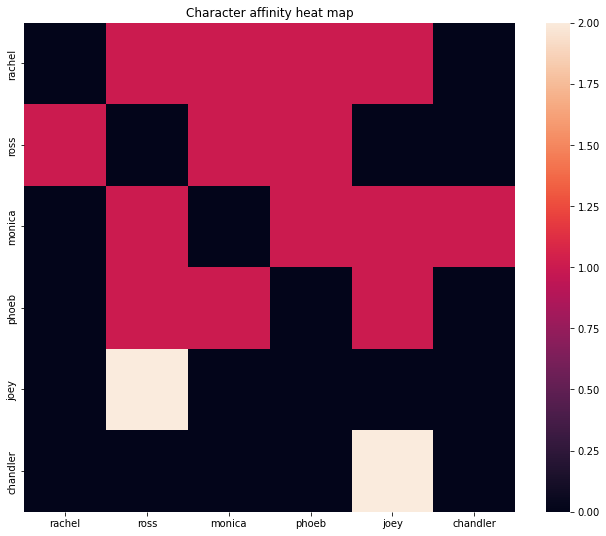

In [297]:
#plotting character affinity heatmap 
#Higher affinity towards one character means higher mentions of another character in the other character's key topics through out
fig, ax = plt.subplots(figsize=(11, 9))
sb.heatmap(ca_df)

# displaying the title 
plt.title("Character affinity heat map")

In [262]:
clean_documents_list=preprocess_data(ross_text)
term_dictionary, doc_term_matrix = prepare_corpus(clean_documents_list)

In [263]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=doc_term_matrix,
                                           id2word=term_dictionary,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

In [273]:
ross_topics2 = lda_model.print_topics(num_topics=number_of_topics, num_words=words)
ross_topics2

[(0,
  '0.048*"go" + 0.047*"get" + 0.041*"rachel" + 0.034*"guy" + 0.033*"look" + 0.032*"god" + 0.029*"right" + 0.027*"uh" + 0.025*"come" + 0.025*"good"'),
 (1,
  '0.102*"oh" + 0.073*"yeah" + 0.038*"well" + 0.031*"want" + 0.029*"say" + 0.025*"ok" + 0.022*"love" + 0.022*"got" + 0.020*"goodby" + 0.020*"never"'),
 (2,
  '0.060*"gonna" + 0.058*"okay" + 0.032*"thing" + 0.024*"one" + 0.020*"sure" + 0.019*"ye" + 0.017*"two" + 0.017*"tell" + 0.016*"wow" + 0.015*"minut"'),
 (3,
  '0.079*"know" + 0.075*"hey" + 0.030*"think" + 0.030*"monica" + 0.029*"realli" + 0.029*"like" + 0.026*"mean" + 0.022*"let" + 0.021*"would" + 0.019*"feel"')]

In [264]:
lda_model.print_topics()

[(0,
  '0.048*"go" + 0.047*"get" + 0.041*"rachel" + 0.034*"guy" + 0.033*"look" + 0.032*"god" + 0.029*"right" + 0.027*"uh" + 0.025*"come" + 0.025*"good"'),
 (1,
  '0.102*"oh" + 0.073*"yeah" + 0.038*"well" + 0.031*"want" + 0.029*"say" + 0.025*"ok" + 0.022*"love" + 0.022*"got" + 0.020*"goodby" + 0.020*"never"'),
 (2,
  '0.060*"gonna" + 0.058*"okay" + 0.032*"thing" + 0.024*"one" + 0.020*"sure" + 0.019*"ye" + 0.017*"two" + 0.017*"tell" + 0.016*"wow" + 0.015*"minut"'),
 (3,
  '0.079*"know" + 0.075*"hey" + 0.030*"think" + 0.030*"monica" + 0.029*"realli" + 0.029*"like" + 0.026*"mean" + 0.022*"let" + 0.021*"would" + 0.019*"feel"')]

In [270]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()


In [298]:
vis = gensimvis.prepare(lda_model, doc_term_matrix, dictionary=lda_model.id2word)
vis

c:\Users\nikhi\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.311388  0.111862       1        1  27.815707
1      0.041994 -0.279430       2        1  25.456770
3      0.217620  0.228473       3        1  25.197133
2      0.051774 -0.060905       4        1  21.530391, topic_info=        Term         Freq        Total Category  logprob  loglift
144       oh  1185.000000  1185.000000  Default  30.0000  30.0000
31      know   909.000000   909.000000  Default  29.0000  29.0000
242      hey   867.000000   867.000000  Default  28.0000  28.0000
142     yeah   852.000000   852.000000  Default  27.0000  27.0000
126    gonna   596.000000   596.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
2035   shoot    54.185037    55.332502   Topic4  -5.2024   1.5147
174   ticket    78.929870    89.062431   Topic4  -4.8263   1.4149
4428    pari    86.374220   103.962056   Topic4  -4.7361   1.3504
1794     uhm    92.068070   149.276569   Topic4  -4.6723   1.0524
762     morn    58.583306    63.987708   Topic4  -5.1244   1.4475

[161 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
304       3  0.994364   actual
21        1  0.015631  alright
21        4  0.984774  alright
117       1  0.992327    anyth
53        2  0.990516      ask
...     ...       ...      ...
169       3  0.995763    would
711       4  0.996371      wow
188       4  0.993245       ye
142       2  0.999509     yeah
81        4  0.994623     year

[157 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 3])

### Dr Healey's Code

In [301]:
ross_text

[' Hi.',
 'I just feel like someone reached down my throat, grabbed my small intestine, pulled it out of my mouth and tied it around my neck...',
 'Thanks.',
 "No, no don't! Stop cleansing my aura! No, just leave my aura alone, okay?",
 "I'll be fine, alright? Really, everyone. I hope she'll be very happy.",
 "No I don't, to hell with her, she left me!",
 "No!! Okay?! Why does everyone keep fixating on that? She didn't know, how should I know?",
 'I told mom and dad last night, they seemed to take it pretty well.',
 'Sorry.',
 "I don't want to be single, okay? I just... I just- I just wanna be married again!",
 'Hi.',
 " I'll have whatever Christine is having.",
 "You can see where he'd have trouble.",
 'Paul the Wine Guy, Paul?',
 'He finally asked you out?',
 " That'd be good...",
 " No, go on! It's Paul the Wine Guy!",
 'A wandering?',
 "So Rachel, what're you, uh... what're you up to tonight?",
 "Right, you're not even getting your honeymoon, God.. No, no, although, Aruba, this tim

In [302]:
import nltk
import re
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

#nltk.download( 'stopwords' )


In [303]:

txt = ross_text

# Split text blocks into sentences

full_sent = []
for i in range(0, len(txt)):
    sent = re.sub(r'[\.!\?]"', '"', txt[i])
    full_sent += re.split('[\.!\?]', sent)
full_sent = [sent.strip() for sent in full_sent]


<>:8: DeprecationWarning: invalid escape sequence \.
<>:8: DeprecationWarning: invalid escape sequence \.
C:\Users\nikhi\AppData\Local\Temp\ipykernel_15396\4047441734.py:8: DeprecationWarning: invalid escape sequence \.
  full_sent += re.split('[\.!\?]', sent)


In [305]:
def preprocess_data(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts

In [306]:
ross_clean = preprocess_data(ross_text)

In [307]:
ross_clean

[['hi'],
 ['feel',
  'like',
  'someon',
  'reach',
  'throat',
  'grab',
  'small',
  'intestin',
  'pull',
  'mouth',
  'tie',
  'around',
  'neck'],
 ['thank'],
 ['stop', 'cleans', 'aura', 'leav', 'aura', 'alon', 'okay'],
 ['fine', 'alright', 'realli', 'everyon', 'hope', 'happi'],
 ['hell', 'left'],
 ['okay', 'everyon', 'keep', 'fixat', 'know', 'know'],
 ['told', 'mom', 'dad', 'last', 'night', 'seem', 'take', 'pretti', 'well'],
 ['sorri'],
 ['want', 'singl', 'okay', 'wanna', 'marri'],
 ['hi'],
 ['whatev', 'christin'],
 ['see', 'troubl'],
 ['paul', 'wine', 'guy', 'paul'],
 ['final', 'ask'],
 ['good'],
 ['go', 'paul', 'wine', 'guy'],
 ['wander'],
 ['rachel', 'uh', 'tonight'],
 ['right',
  'even',
  'get',
  'honeymoon',
  'god',
  'although',
  'aruba',
  'time',
  'year',
  'talk',
  'big',
  'lizard',
  'anyway',
  'feel',
  'like',
  'alon',
  'tonight',
  'joey',
  'chandler',
  'come',
  'help',
  'put',
  'togeth',
  'new',
  'furnitur'],
 ['okay', 'sure'],
 ['suppos',
  'attach

In [ ]:

# Remove empty sentences

i = 0
while i < len(full_sent):
    if len(full_sent[i]) == 0:
        del full_sent[i]
    else:
        i += 1

# Remove punctuation

sent = []

punc = string.punctuation.replace('-', '')
for i in range(0, len(full_sent)):
    sent.append(re.sub('[' + punc + ']+', '', full_sent[i]))

# Porter stem

porter = nltk.stem.porter.PorterStemmer()
stems = {}

for i in range(0, len(sent)):
    tok = sent[i].split()
    for j in range(0, len(tok)):
        if tok[j] not in stems:
            stems[tok[j]] = porter.stem(tok[j])
        tok[j] = stems[tok[j]]

    sent[i] = ' '.join(tok)

# Remove empty sentences after stop word removal

i = 0
while i < len(sent):
    if len(sent[i]) == 0:
        del sent[i]
    else:
        i += 1

# Convert frequencies to TF-IDF values, get cosine similarity
# of all pairs of documents


In [308]:
tfidf = TfidfVectorizer(stop_words='english', max_df=0.8, max_features=1000)
term_vec = tfidf.fit_transform(ross_clean)

AttributeError: 'list' object has no attribute 'lower'

In [ ]:

tfidf = TfidfVectorizer(stop_words='english', max_df=0.8, max_features=1000)
term_vec = tfidf.fit_transform(sent)
X = cosine_similarity(term_vec)

# Fit vectors to clusters

clust = KMeans(n_clusters=5, random_state=1).fit(X)
print(clust.labels_)

for i in range(0, len(set(clust.labels_))):
    print(f'Cluster {i}:')

    for j in range(0, len(clust.labels_)):
        if clust.labels_[j] == i:
            print(full_sent[j].replace('"', '').strip())

    print()


##### Experimentation Code Below

In [51]:
lines_list
lines_list = [x for x in lines_list if x]

In [52]:
lines_list

['The One Where Monica Gets a New Roommate (The Pilot-The Uncut Version)',
 'Written by: Marta Kauffman & David Crane',
 '[Scene: Central Perk, Chandler, Joey, Phoebe, and Monica are there.]',
 "Monica: There's nothing to tell! He's just some guy I work with!",
 "Joey: C'mon, you're going out with the guy! There's gotta be something wrong with him!",
 'Chandler: All right Joey, be nice.  So does he have a hump? A hump and a hairpiece?',
 'Phoebe: Wait, does he eat chalk?',
 '(They all stare, bemused.)',
 "Phoebe: Just, 'cause, I don't want her to go through what I went through with Carl- oh!",
 "Monica: Okay, everybody relax. This is not even a date. It's just two people going out to dinner and- not having sex.",
 'Chandler: Sounds like a date to me.',
 '[Time Lapse]',
 "Chandler: Alright, so I'm back in high school, I'm standing in the middle of the cafeteria, and I realize I am totally naked.",
 'All: Oh, yeah. Had that dream.',
 "Chandler: Then I look down, and I realize there's a p

In [57]:
data = []
for line in lines_list:
    # print(line)
    if ":" in line:
        splitline = line.split(': ',maxsplit=1)
        #print(splitline[0])
        if splitline[0] in names:
            data.append(splitline)

In [58]:
data

[['Monica', "There's nothing to tell! He's just some guy I work with!"],
 ['Joey',
  "C'mon, you're going out with the guy! There's gotta be something wrong with him!"],
 ['Chandler',
  'All right Joey, be nice.  So does he have a hump? A hump and a hairpiece?'],
 ['Phoebe', 'Wait, does he eat chalk?'],
 ['Phoebe',
  "Just, 'cause, I don't want her to go through what I went through with Carl- oh!"],
 ['Monica',
  "Okay, everybody relax. This is not even a date. It's just two people going out to dinner and- not having sex."],
 ['Chandler', 'Sounds like a date to me.'],
 ['Chandler',
  "Alright, so I'm back in high school, I'm standing in the middle of the cafeteria, and I realize I am totally naked."],
 ['Chandler', "Then I look down, and I realize there's a phone... there."],
 ['Joey', 'Instead of...?'],
 ['Chandler', "That's right."],
 ['Joey', 'Never had that dream.'],
 ['Phoebe', 'No.'],
 ['Chandler',
  "All of a sudden, the phone starts to ring. Now I don't know what to do, everybo

In [59]:
for value in range(len(data)):
    if len(data[value]) > 2:
        print(value)
        print(data[value], '\n')

In [60]:
def remove_scene_details(line):
    clean_line = re.sub("[\(\[].*?[\)\]]", "", line)
    return clean_line

In [61]:
for value in data:
    line = value[1]
    bracket_count = line.count("(")
    #print(bracket_count)
    if bracket_count == 0:
        continue
    else:
        print(line)
        clean_line = remove_scene_details(line)
        print(clean_line)
    
    value[1] = clean_line

(mortified) Hi.
 Hi.
(explaining to the others) Carol moved her stuff out today.
 Carol moved her stuff out today.
(to Ross) Let me get you some coffee.
 Let me get you some coffee.
Ooh! Oh! (She starts to pluck at the air just in front of Ross.)
Ooh! Oh! 
Sometimes I wish I was a lesbian... (They all stare at him.) Did I say that out loud?
Sometimes I wish I was a lesbian...  Did I say that out loud?
And I just want a million dollars! (He extends his hand hopefully.)
And I just want a million dollars! 
(pointing at Rachel) De-caff. (to All) Okay, everybody, this is Rachel, another Lincoln High survivor. (to Rachel) This is everybody, this is Chandler, and Phoebe, and Joey, and- you remember my brother Ross?
 De-caff.  Okay, everybody, this is Rachel, another Lincoln High survivor.  This is everybody, this is Chandler, and Phoebe, and Joey, and- you remember my brother Ross?
Oh God... well, it started about a half hour before the wedding. I was in the room where we were keeping all the

In [37]:
x = "(points at the baby she's holding) This is a boy, (points at the baby Chandler is holding) and that's a girl."


In [38]:
re.sub("[\(\[].*?[\)\]]", "", x)

" This is a boy,  and that's a girl."

In [62]:
data

[['Monica', "There's nothing to tell! He's just some guy I work with!"],
 ['Joey',
  "C'mon, you're going out with the guy! There's gotta be something wrong with him!"],
 ['Chandler',
  'All right Joey, be nice.  So does he have a hump? A hump and a hairpiece?'],
 ['Phoebe', 'Wait, does he eat chalk?'],
 ['Phoebe',
  "Just, 'cause, I don't want her to go through what I went through with Carl- oh!"],
 ['Monica',
  "Okay, everybody relax. This is not even a date. It's just two people going out to dinner and- not having sex."],
 ['Chandler', 'Sounds like a date to me.'],
 ['Chandler',
  "Alright, so I'm back in high school, I'm standing in the middle of the cafeteria, and I realize I am totally naked."],
 ['Chandler', "Then I look down, and I realize there's a phone... there."],
 ['Joey', 'Instead of...?'],
 ['Chandler', "That's right."],
 ['Joey', 'Never had that dream.'],
 ['Phoebe', 'No.'],
 ['Chandler',
  "All of a sudden, the phone starts to ring. Now I don't know what to do, everybo

In [63]:
dialogues_df = pd.DataFrame(data, columns = ["Name", "Line"])

In [66]:
dialogues_df

,Name,Line
0,Monica,There's nothing to tell! He's just some guy I ...
1,Joey,"C'mon, you're going out with the guy! There's ..."
2,Chandler,"All right Joey, be nice. So does he have a hu..."
3,Phoebe,"Wait, does he eat chalk?"
4,Phoebe,"Just, 'cause, I don't want her to go through w..."
...,...,...
260,Chandler,"Did you make it, or are you just serving it?"
261,Rachel,I'm just serving it.
262,Chandler,"Kids, new dream... I'm in Las Vegas."
263,Rachel,"Ugh. Excuse me, could you give this to that g..."


In [79]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer


In [81]:
nltk.download([
    "names",
    "stopwords",
    "state_union",
    "twitter_samples",
    "movie_reviews",
    "averaged_perceptron_tagger",
    "vader_lexicon",
    "punkt",])


[nltk_data] Downloading package names to
[nltk_data]     C:\Users\nikhi\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\names.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nikhi\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package state_union to
[nltk_data]     C:\Users\nikhi\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\state_union.zip.
[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\nikhi\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\twitter_samples.zip.
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\nikhi\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\movie_reviews.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\nikhi\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.
[nltk_data] Downloading package vader_

True

In [69]:
lines = dialogues_df["Line"]

In [82]:
sia = SentimentIntensityAnalyzer()

In [92]:
lines[5]

"Okay, everybody relax. This is not even a date. It's just two people going out to dinner and- not having sex."

In [116]:
f = sia.polarity_scores("Ugh.  Excuse me, could you give this to that guy over there?  Go ahead.  Thank you.  Sorry.  Okay, Las Vegas.")

In [117]:
f

{'neg': 0.165, 'neu': 0.605, 'pos': 0.23, 'compound': 0.1531}

In [118]:
scores = f['pos'], f['neg'], f['neu']

In [119]:
scores

(0.23, 0.165, 0.605)

In [120]:
def calculate_sentiment(dialogue):
    f = sia.polarity_scores(dialogue.strip())
    scores = f['pos'], f['neg'], f['neu']
    return scores

In [121]:
scores_list = []
for index, value in dialogues_df.iterrows():
    print(value["Line"])
    dialogue = value["Line"]
    scores = calculate_sentiment(dialogue)
    scores_list.append(scores)
    


There's nothing to tell! He's just some guy I work with!
C'mon, you're going out with the guy! There's gotta be something wrong with him!
All right Joey, be nice.  So does he have a hump? A hump and a hairpiece?
Wait, does he eat chalk?
Just, 'cause, I don't want her to go through what I went through with Carl- oh!
Okay, everybody relax. This is not even a date. It's just two people going out to dinner and- not having sex.
Sounds like a date to me.
Alright, so I'm back in high school, I'm standing in the middle of the cafeteria, and I realize I am totally naked.
Then I look down, and I realize there's a phone... there.
Instead of...?
That's right.
Never had that dream.
No.
All of a sudden, the phone starts to ring. Now I don't know what to do, everybody starts looking at me.
And they weren't looking at you before?!
Finally, I figure I'd better answer it, and it turns out it's my mother, which is very-very weird, because- she never calls me!
 Hi.
This guy says hello, I wanna kill myself

In [125]:
scores_df = pd.DataFrame(scores_list, columns=['Positive','Negative','Neutral'])

In [126]:
scores_df

,Positive,Negative,Neutral
0,0.000,0.000,1.000
1,0.000,0.221,0.779
2,0.208,0.000,0.792
3,0.000,0.000,1.000
4,0.000,0.104,0.896
...,...,...,...
260,0.000,0.000,1.000
261,0.000,0.000,1.000
262,0.000,0.000,1.000
263,0.230,0.165,0.605


In [128]:
final_df = pd.concat([dialogues_df, scores_df],axis=1)

In [136]:
final_df[final_df['Neutral']> 0.5]

,Name,Line,Positive,Negative,Neutral
0,Monica,There's nothing to tell! He's just some guy I ...,0.000,0.000,1.000
1,Joey,"C'mon, you're going out with the guy! There's ...",0.000,0.221,0.779
2,Chandler,"All right Joey, be nice. So does he have a hu...",0.208,0.000,0.792
3,Phoebe,"Wait, does he eat chalk?",0.000,0.000,1.000
4,Phoebe,"Just, 'cause, I don't want her to go through w...",0.000,0.104,0.896
...,...,...,...,...,...
260,Chandler,"Did you make it, or are you just serving it?",0.000,0.000,1.000
261,Rachel,I'm just serving it.,0.000,0.000,1.000
262,Chandler,"Kids, new dream... I'm in Las Vegas.",0.000,0.000,1.000
263,Rachel,"Ugh. Excuse me, could you give this to that g...",0.230,0.165,0.605
